In [70]:
# MAIN FUNCTIONS #

"""
INPUT:   G = directed/oriented graph with vertices labeled 0,...,(n-1)
OUTPUT:  a zero forcing set & throttling number
"""
def throttle(G):
    n = G.order()
    nbrs = get_out_nbrs(G)
    
    throt_num = n
    zfs = [x for x in range(n)]
    
    for b in range(1,n):
        for B in Combinations(range(n), b):
            filled, prop_time = push_zeros(nbrs, B, n)
            if len(filled) == n:  # all blue?
                if b + prop_time < throt_num:
                    zfs = B
                    throt_num = b + prop_time
                    
        if throt_num < b + 1:
            return zfs, throt_num
        
    return zfs, throt_num

"""
INPUT:   G = directed/oriented graph with vertices labeled 0,...,(n-1)
         B = List of a subset of V(G)
         wantChains (optional arg, False by default) = whether to output forcing chains
OUTPUT:  prop_time = pt(G;B) (returns math.inf if infinite)
         chains (optional) = maximal forcing chains when forcing G using B
"""
def prop_time(G, B, wantChains=False):
    nbrs = get_out_nbrs(G)
    n = G.order()
    if wantChains:
        filled, prop_time, chains = push_zeros(nbrs, B, n, wantChains=True)
    else:
        filled, prop_time = push_zeros(nbrs, B, n)
        
    if len(filled) != n:
        prop_time = math.inf
    
    if wantChains:
        return prop_time, chains
    return prop_time

"""
INPUT:   chains = 2-d array of maximal forcing chains
OUTPUT:  the terminus, aka the last vertices of the forcing chains
"""
def get_terminus(chains):
    return [chain[-1] for chain in chains]

In [71]:

# HELPER FUNCTIONS #

"""
Adapted from: https://sage.math.iastate.edu/home/pub/74/
INPUT:   G = graph
OUTPUT:  nbrs = list of outneighbors of G (e.g. nbrs[0] = outneighbors of vertex 0)
"""
def get_out_nbrs(G):
    n = G.order()
    nbrs = []  # Find lists of out neighbors (for push_zeros)
    for v in range(n):
        out_nbrs = []
        for e in G.outgoing_edges(v):
            if e[0]==v:
                out_nbrs.append(e[1])
            else:
                out_nbrs.append(e[0])
        nbrs.append(out_nbrs)
    return nbrs

"""
Adapted from: https://sage.math.iastate.edu/home/pub/74/
INPUT:   nbrs = a list of all out-neighbors of each vertex
         B = an initial set of "blue" vertices
         n = number of vertices in graph
         wantChains (False by default) = whether to output forcing chains or not
OUTPUT:  filled = the set of all vertices forced under repeated
         prop_time = how many iteration of the color change rule
         chains (optional) = 2-d list of maximal forcing chains
"""
def push_zeros(nbrs, B, n, wantChains=False):
    active = set(B)
    filled = set(B)
    unfilled = set(range(n)).difference(filled)
    force = True
    prop_time = -1
    chains = [[v] for v in active]
    
    while force:  # keep going until no more forces happen
        prop_time += 1
        force = False
        
        # copy to be careful with prop time
        new_active = active.copy()
        new_filled = filled.copy()
        new_unfilled = unfilled.copy()
        
        for v in active:  # check each blue vertex which might force
            white_nbrs = set(nbrs[v]).intersection(unfilled)
            if len(white_nbrs) == 0:  # if no white neighbors, remove from active
                new_active.remove(v)
            elif len(white_nbrs) == 1:  # one white neighbor so can force
                w = white_nbrs.pop()
                new_filled.add(w)  # w is now blue
                if w in new_unfilled: # no other vertex in this time step has forced w yet
                    force = True 
                    new_unfilled.remove(w)
                    # Add to forcing chains
                    if wantChains:
                        for chain in chains:
                            if chain[-1] == v:
                                chain.append(w)
                new_active.add(w)
                new_active.remove(v)
        active = new_active.copy()
        filled = new_filled.copy()
        unfilled = new_unfilled.copy()
        
    if wantChains:
        return filled, prop_time, chains
    return filled, prop_time

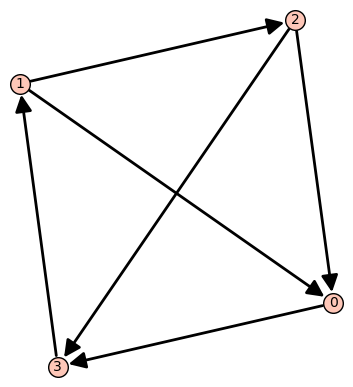

In [72]:
# Tournament on 4 vertices with min throttling num
G1=DiGraph(4)
G1.add_edges([(1,0),(3,1),(0,3),(2,0),(2,3),(1,2),(0,3)])
G1.show()

In [73]:
zfs, th = throttle(G1)
print('Throttling Number for G1:', th)
print('Zero Forcing Set:', zfs)

Throttling Number for G1: 3
Zero Forcing Set: [0, 1]


In [74]:
B = [0,2]
pt = prop_time(G1, B)
print('Prop Time for G1 using B:', pt)
pt, chains = prop_time(G1, B, wantChains=True)
print('Forcing Chains for G1 using B:', chains)
term_B = get_terminus(chains)

Prop Time for G1 using B: 2
Forcing Chains for G1 using B: [[0, 3, 1], [2]]


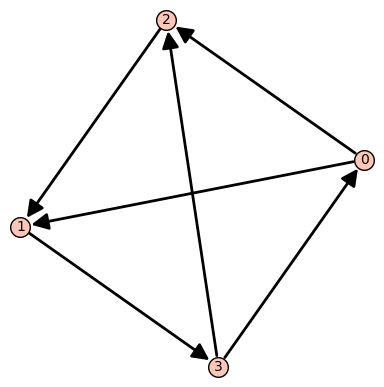

In [75]:
G1_T = G1.reverse()
G1_T.show()

In [76]:
pt, chains = prop_time(G1_T, term_B, wantChains=True)
print('Prop Time for G1^T using Term(B):', pt)
print('Forcing Chains for G1^T using Term(B):', chains)

Prop Time for G1^T using Term(B): 2
Forcing Chains for G1^T using Term(B): [[1, 3, 0], [2]]


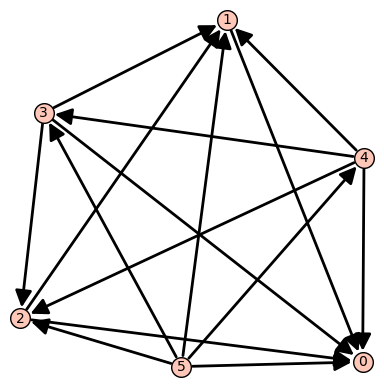

In [77]:
# Tournament on 6 vertices with max throttling num
M = matrix([[0,0,0,0,0,0],
            [1,0,0,0,0,0],
            [1,1,0,0,0,0],
            [1,1,1,0,0,0],
            [1,1,1,1,0,0],
            [1,1,1,1,1,0]])
G2 = DiGraph(M)
G2.show() 

In [78]:
zfs, th = throttle(G2)
print('Throttling Number for G2:', th)
print('Zero Forcing Set:', zfs)

Throttling Number for G2: 6
Zero Forcing Set: [0, 1, 2, 3, 4, 5]


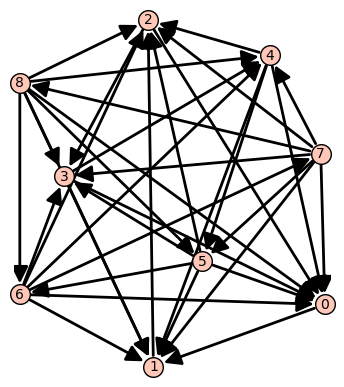

In [79]:
# Complete Hessenberg path on 9 vertices
M = matrix([[0,1,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0],
            [1,0,0,1,0,0,0,0,0],
            [1,1,0,0,1,0,0,0,0],
            [1,1,1,0,0,1,0,0,0],
            [1,1,1,1,0,0,1,0,0],
            [1,1,1,1,1,0,0,1,0],
            [1,1,1,1,1,1,0,0,1],
            [1,1,1,1,1,1,1,0,0]])
G3 = DiGraph(M)
G3.show() 

In [15]:
zfs, th = throttle(G3)
print('Throttling Number for G3:', th)
print('Zero Forcing Set:', zfs)

Throttling Number for G3: 7
Zero Forcing Set: [0, 2, 5]
